In [1]:
import pandas as pd 
from sqlalchemy import create_engine
server = 'rice-sqlcl-db'
database = 'SharadarEquity'
username = 'stocks'
password = '6LAZH1'
string = f"mssql+pymssql://{username}:{password}@{server}/{database}"
conn = create_engine(string).connect() 
df = pd.read_sql("select * from ghz", conn)
df = df.dropna(subset=["date"])

In [2]:
prices =pd.read_sql("select * from prices where date >= '2020-01-01' and date < '2025-04-16'", conn)
metrics = pd.read_sql("select * from metrics where date >= '2020-01-01' and date < '2025-04-16'", conn)
tickers = pd.read_sql("select * from tickers", conn)

In [3]:
df = prices.merge(metrics, left_on = ["date", "ticker"], right_on=["date", "ticker"], how="inner")
df = df.merge(tickers[["ticker", "industry", "sector"]], left_on="ticker", right_on="ticker", how="inner")
df = df.drop(columns=["lastupdated_x", "lastupdated_y"])
df = df.rename(columns={"opn": "open"})
df = df.sort_values(by=["ticker", "date"])
df = df.set_index(["ticker", "date"])

In [4]:
df["lag52"] = df.groupby("ticker", group_keys=False).closeadj.apply(lambda x: x/x.shift(52)-1)
df["lag26"] = df.groupby("ticker", group_keys=False).closeadj.apply(lambda x: x/x.shift(26)-1)
df["lag4"] = df.groupby("ticker", group_keys=False).closeadj.apply(lambda x: x/x.shift(4)-1)
df["lag1"] = df.groupby("ticker", group_keys=False).closeadj.apply(lambda x: x/x.shift(1)-1)
df["ret"] = df.groupby("ticker", group_keys=False).closeadj.apply(lambda x: x.shift(-1)/x-1)
for col in ["lag52", "lag26", "lag4", "lag1", "ret"]:
    df[col] = 100*df[col]
df = df.dropna()
df["rnk"] = df.groupby("date", group_keys=False).marketcap.rank(ascending=False,method="first")
df = df.reset_index()
df = df[(df.rnk>1000) & (df.rnk<=2000)]
df = df[df.date.astype(str) >= "2021-01-01"].copy()
df.date = pd.to_datetime(df.date)

In [5]:
df.to_csv("stocks.csv")

In [6]:
df2 = df[df.date==df.date.max()]
import statsmodels.api as sm
X = df2[["pb", "lag52", "lag4", "rsi"]]
X = sm.add_constant(X)
model = sm.OLS(endog=df2.ret, exog=X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     11.98
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           1.64e-09
Time:                        08:47:56   Log-Likelihood:                -3355.5
No. Observations:                1000   AIC:                             6721.
Df Residuals:                     995   BIC:                             6746.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0012      1.390     -2.159      0.031      -5.729      -0.273
pb             0.0423      0.016      2.631      0.009       0.011       0.074
lag52          0.0193      0.004      4.912      0.000       0.012       0.027
lag4          -0.1241      0.028     -4.406      0.000      -0.179      -0.069
rsi            0.0772      0.034      2.266      0.024       0.010       0.144
==============================================================================
Omnibus:                      175.791   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              730.719
Skew:                           0.770   Prob(JB):                    2.12e-159
Kurtosis:                       6.894   Cond. No.                         378.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# Convert the regression results table to LaTeX format with coefficients rounded to 3 decimal places
latex_table = result.summary().tables[1].as_latex_tabular()

# Modify the LaTeX table to round coefficients to 3 decimal places
import re
def round_numbers(match):
    try:
        num = float(match.group(0))
        return f"{num:.3f}"
    except:
        return match.group(0)

# Apply rounding to numbers in the LaTeX table
latex_table = re.sub(r'-?\d+\.\d+', round_numbers, latex_table)

# Display the LaTeX table
print(latex_table)

\begin{center}
\begin{tabular}{lcccccc}
\toprule
               & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const} &      -3.001  &        1.390     &    -2.159  &         0.031        &       -5.729    &       -0.273     \\
\textbf{pb}    &       0.042  &        0.016     &     2.631  &         0.009        &        0.011    &        0.074     \\
\textbf{lag52} &       0.019  &        0.004     &     4.912  &         0.000        &        0.012    &        0.027     \\
\textbf{lag4}  &      -0.124  &        0.028     &    -4.406  &         0.000        &       -0.179    &       -0.069     \\
\textbf{rsi}   &       0.077  &        0.034     &     2.266  &         0.024        &        0.010    &        0.144     \\
\bottomrule
\end{tabular}
\end{center}


In [8]:
df.date.max()

Timestamp('2025-04-04 00:00:00')

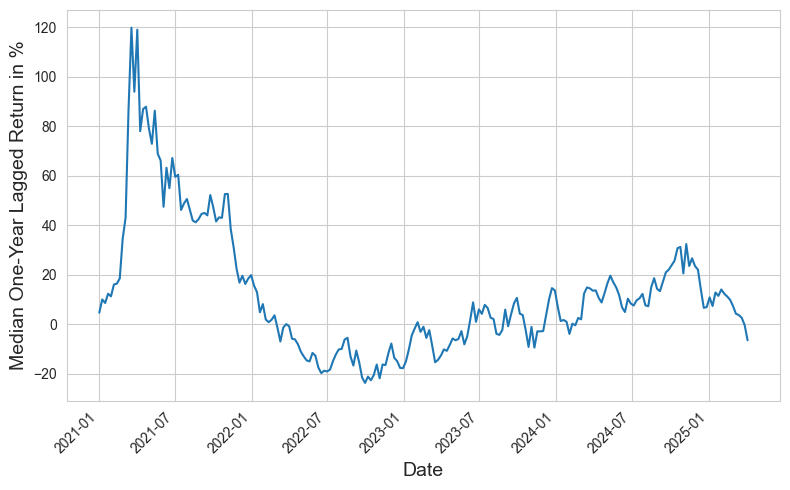

In [9]:
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
plt.figure(figsize=(8, 5))
# Configure date display on x-axis
rcParams['axes.formatter.use_locale'] = True
sns.set_style("whitegrid")

pb = df.groupby("date").lag52.median()
pb.index = pd.to_datetime(pb.index)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Median One-Year Lagged Return in %", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.plot(pb)

plt.tight_layout()
plt.savefig("latex/lagret.pdf")
plt.show()